# Project Introduction

- Project Background  

Employee turnover is a critical issue for organizations. Early attrition, especially within the first 1–2 years of employment, leads to increased recruitment costs, onboarding inefficiencies, and productivity loss.

This notebook explores the key factors influencing employee attrition through:

-- Descriptive statistical analysis

-- Correlation analysis

-- Comparative analysis across key variables

The objective is to identify the primary drivers of employee turnover and provide data-driven insights to support strategic HR decision-making and organizational retention policies.

- Data source

https://www.kaggle.com/mizanhadi/hr-employee-data-visualisation/data?select=HR_comma_sep.csv


- Data Description

The file HR_comma_sep.csv contains 10 variables describing employee characteristics, performance metrics, and organizational attributes.


| No. | Feature               | Data Type            | Description                                                               |
| --- | --------------------- | -------------------- | ------------------------------------------------------------------------- |
| 1   | satisfaction_level    | Float                | Employee satisfaction level (0 = low satisfaction, 1 = high satisfaction) |
| 2   | last_evaluation       | Float                | Most recent performance evaluation score (range: 0–1)                     |
| 3   | number_project        | Integer              | Number of projects completed during employment                            |
| 4   | average_monthly_hours | Integer              | Average monthly working hours                                             |
| 5   | time_spend_company    | Integer              | Years spent at the company                                                |
| 6   | work_accident         | Integer (Binary)     | Whether the employee experienced a workplace accident (0 = No, 1 = Yes)   |
| 7   | left                  | Integer (Binary)     | Attrition status (0 = Currently employed, 1 = Left the company)           |
| 8   | promotion_last_5years | Integer (Binary)     | Whether the employee was promoted in the last 5 years (0 = No, 1 = Yes)   |
| 9   | sales                 | String (Categorical) | Department or business unit                                               |
| 10  | salary                | String (Categorical) | Relative salary level (low, medium, high)                                 |

- Target Variable

The primary target variable in this analysis is:

left

0 → Employee retained

1 → Employee attrited



In [10]:
%pip install plotly
%pip install colorlover

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
from plotly import __version__
print (__version__)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from plotly.graph_objs import *
import colorlover as cl
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

5.24.1


## 1.Data Inspection and Understanding

In [4]:
colors = ['#e43620', '#f16d30','#d99a6c','#fed976', '#b3cb95', '#41bfb3','#229bac', '#256894']
data = pd.read_csv('/kaggle/input/hr-data/HR_comma_sep.csv')

data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
print("There are", data.shape[0], "employee records and", data.shape[1], "employee features.")


There are 14999 employee records and 10 employee features.


### 1.1. Check for missing values

In [6]:
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

### 1.2. Rename feature columns

In [7]:
df = data.rename(columns = {"sales":"department","promotion_last_5years":"promotion","Work_accident":"work_accident"})
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion', 'department', 'salary'],
      dtype='object')

### 1.3. View dataset information

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   satisfaction_level    14999 non-null  float64
 1   last_evaluation       14999 non-null  float64
 2   number_project        14999 non-null  int64  
 3   average_montly_hours  14999 non-null  int64  
 4   time_spend_company    14999 non-null  int64  
 5   work_accident         14999 non-null  int64  
 6   left                  14999 non-null  int64  
 7   promotion             14999 non-null  int64  
 8   department            14999 non-null  object 
 9   salary                14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### 1.4. Display information for all categorical features

In [9]:
df.describe(include=['O'])

,department,salary
count,14999,14999
unique,10,3
top,sales,low
freq,4140,7316


### 1.5. Categorical Encoding
1. First, set the `salary` and `department` columns to the Category data type.
2. Save the mapping dictionary between categories and their corresponding numeric codes.
3. For the categorical features `salary` and `department` (`Object` type), convert them into numerical representations.

In [ ]:
# 1. First, set the salary and department columns to the Category data type.
df['department'] = df['department'].astype('category')#, categories=cat.categories)
df['salary'] = df['salary'].astype('category')#, categories=cat.categories)

df.info()

# department_categories = pd.Categorical(df['department']).categories
# salary_categories = pd.Categorical(df['salary']).categories

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   satisfaction_level    14999 non-null  float64 
 1   last_evaluation       14999 non-null  float64 
 2   number_project        14999 non-null  int64   
 3   average_montly_hours  14999 non-null  int64   
 4   time_spend_company    14999 non-null  int64   
 5   work_accident         14999 non-null  int64   
 6   left                  14999 non-null  int64   
 7   promotion             14999 non-null  int64   
 8   department            14999 non-null  category
 9   salary                14999 non-null  category
dtypes: category(2), float64(2), int64(6)
memory usage: 967.4 KB


In [11]:
# 2. Save the mapping dictionary between categories and their corresponding numeric codes.
salary_dict = dict(enumerate(df['salary'].cat.categories))
department_dict = dict(enumerate(df['department'].cat.categories))
salary_dict,department_dict

({0: 'high', 1: 'low', 2: 'medium'},
 {0: 'IT',
  1: 'RandD',
  2: 'accounting',
  3: 'hr',
  4: 'management',
  5: 'marketing',
  6: 'product_mng',
  7: 'sales',
  8: 'support',
  9: 'technical'})

In [12]:
# 3. For the categorical features salary and department (Object type), convert them into numerical representations.
for feature in df.columns:
    if str(df[feature].dtype) == 'category':
        df[feature] = df[feature].cat.codes
        # df[feature] = pd.Categorical(df[feature]).codes
        df[feature] = df[feature].astype("int64") # Set the data type to int64

In [13]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,7,1
1,0.80,0.86,5,262,6,0,1,0,7,2
2,0.11,0.88,7,272,4,0,1,0,7,2
3,0.72,0.87,5,223,5,0,1,0,7,1
4,0.37,0.52,2,159,3,0,1,0,7,1


### 1.6. Reordering Columns
1.First, define the desired column order
	- Move the `left` column to the last position for clearer visualization
    
2.Apply the reordered column list to the DataFrame

In [14]:
cols = df.columns
cols = list(cols[:6]) + list(cols[7:]) + [cols[6]]
print('Reordered Columns:',cols)

Reordered Columns: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'work_accident', 'promotion', 'department', 'salary', 'left']


In [15]:
# Apply the reordered column list to the DataFrame
df = df[cols]
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion,department,salary,left
0,0.38,0.53,2,157,3,0,0,7,1,1
1,0.80,0.86,5,262,6,0,0,7,2,1
2,0.11,0.88,7,272,4,0,0,7,2,1
3,0.72,0.87,5,223,5,0,0,7,1,1
4,0.37,0.52,2,159,3,0,0,7,1,1


In [16]:
print(df.shape)
df.info()

(14999, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   satisfaction_level    14999 non-null  float64
 1   last_evaluation       14999 non-null  float64
 2   number_project        14999 non-null  int64  
 3   average_montly_hours  14999 non-null  int64  
 4   time_spend_company    14999 non-null  int64  
 5   work_accident         14999 non-null  int64  
 6   promotion             14999 non-null  int64  
 7   department            14999 non-null  int64  
 8   salary                14999 non-null  int64  
 9   left                  14999 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


## 2.Exploratory Data Analysis


### 2.1. Descriptive Analysis
Group by the `left` column and perform descriptive analysis

Examine the mean of each feature for both retained and attrited employees

In [17]:
left_summary = df.groupby(by=['left'])
left_summary.mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion,department,salary
left,,,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251,5.819041,1.347742
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321,6.035284,1.345842


In [18]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion,department,salary,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268,5.870525,1.347290,0.238083
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281,2.868786,0.625819,0.425924
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,4.000000,1.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,7.000000,1.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,8.000000,2.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,9.000000,2.000000,1.000000


### 2.2. Correlation Analysis

Based on the heatmap, the following relationships can be observed:

- `satisfaction_level`
  - Employee **satisfaction** (`satisfaction_level`) shows a strong **negative correlation** (−) with **attrition** (`left`).  
  - It also has a moderate negative correlation with the **number of projects** (`number_project`) and **years spent at the company** (`time_spend_company`).

- `last_evaluation`
  - The most recent **performance evaluation** (`last_evaluation`) shows a strong **positive correlation** (+) with both **number of projects** (`number_project`) and **average monthly hours** (`average_monthly_hours`).  
  - This indicates that employees who complete more projects and work longer hours tend to receive higher evaluation scores.
  - However, performance evaluation has little correlation with **salary** or **promotion**, suggesting that higher evaluation scores do not necessarily lead to promotions or salary increases.

- `left`
  - **Attrition** (`left`) shows a **negative correlation** (−) with **employee satisfaction** (`satisfaction_level`), **promotion in the last 5 years** (`promotion_last_5years`), **work accidents** (`work_accident`), and **salary level** (`salary`).  
  - Employees with lower satisfaction and limited career advancement opportunities are more likely to leave the company.
  - Attrition shows a relatively strong **positive correlation** (+) with **years spent at the company** (`time_spend_company`).  
  - It also has a slight positive correlation with **average monthly hours** (`average_monthly_hours`) and **department** (`department`).


In [19]:
corr = df.corr()                 # Pearson Correlation Coefficient
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)]=True

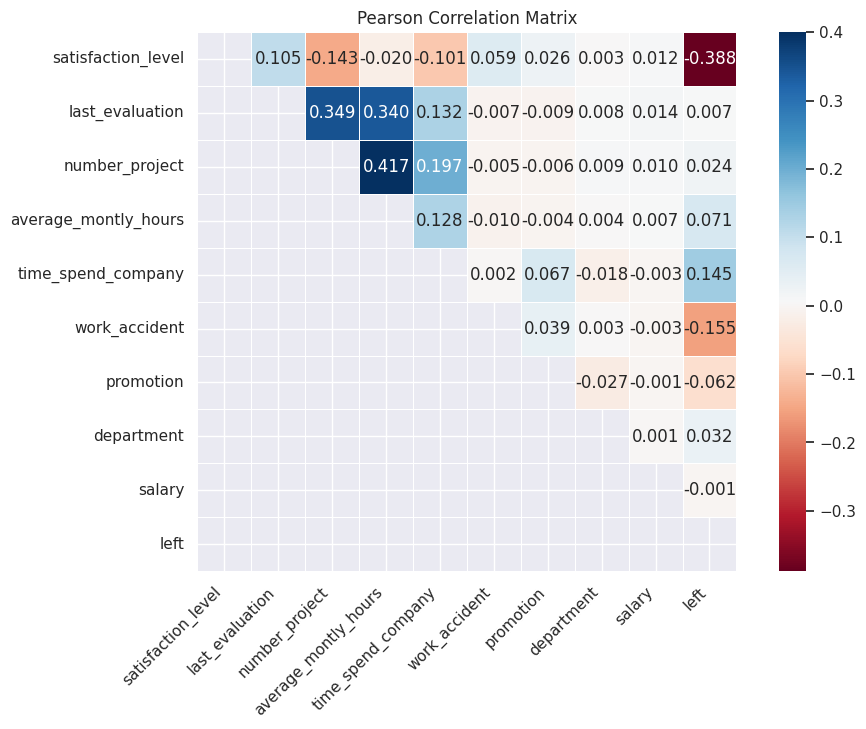

In [20]:
with sns.axes_style("white"):
    sns.set(rc={'figure.figsize': (11, 7)})
    ax = sns.heatmap(
        corr,
        xticklabels=True,
        yticklabels=True,
        cmap='RdBu',          # Color map
        mask=mask,            # Apply mask to display only part of the matrix
        fmt='.3f',            # Number format
        annot=True,           # Show correlation values in each cell
        linewidths=.5,        # Line width between cells
        vmax=.4,              # Maximum value for the color scale
        square=True
        # center=0
    )

plt.title("Pearson Correlation Matrix")
label_x = ax.get_xticklabels()
plt.setp(label_x, rotation=45, horizontalalignment='right')
plt.show()


Attrition is primarily driven by employee satisfaction, rather than performance evaluation or salary level.

The data suggests that emotional and engagement-related factors play a stronger role than compensation or performance metrics.

### 2.3. Variable Analysis
#### 2.3.1. Proportion of Attrited vs. Active Employees

In [42]:
left_count = df['left'].value_counts().reset_index(name = "left_count")

In [43]:
df = df.fillna('')

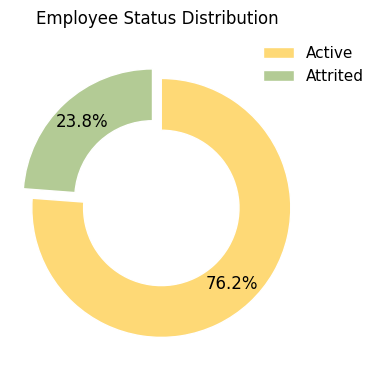

In [51]:

labels = ['Active', 'Attrited']
values = left_count['left_count'].values
colors_mat = colors[3:5]  

plt.figure(figsize=(4, 4))

wedges, texts, autotexts = plt.pie(
    values,
    labels=None,
    colors=colors_mat,
    startangle=90,
    counterclock=False,
    explode=(0, 0.1),          # pull=0.1
    autopct='%1.1f%%',
    pctdistance=0.8,
    wedgeprops=dict(width=0.4, edgecolor='white')  
)

plt.title("Employee Status Distribution")

plt.legend(wedges,labels,loc="upper right",bbox_to_anchor=(1.25, 1),frameon=False)

plt.axis('equal')
plt.tight_layout()
plt.show()


Although the majority of employees remain with the company, the attrition rate of approximately 24% indicates a meaningful turnover issue that warrants deeper structural analysis.

Further analysis of the key drivers of attrition is required.

The overall proportion only reflects a macro-level situation. The critical questions are:

- Which employee groups are more likely to leave?

- Is attrition associated with factors such as satisfaction, salary, promotion, or working hours?

- Are there significant differences across departments?

#### 2.3.2. Relationship Between Employee Satisfaction and Years at the Company

In [52]:
# Calculate the mean satisfaction level

time_mean_satifaction = df.groupby(
    by = ['time_spend_company'])['satisfaction_level'].mean().reset_index(name = "average_satisfaction") 

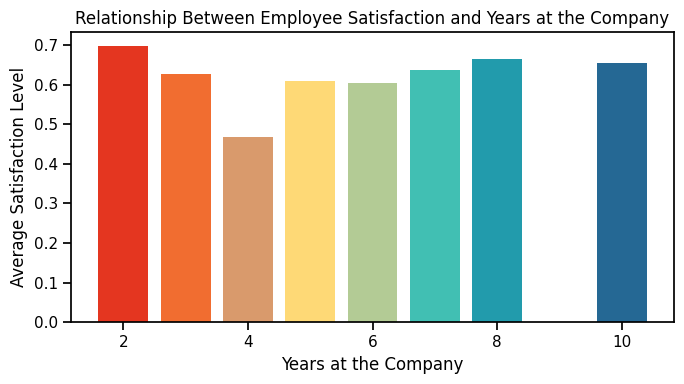

In [53]:


plt.figure(figsize=(7, 4))

plt.bar(
    time_mean_satifaction.time_spend_company,
    time_mean_satifaction.average_satisfaction,
    color=colors[:len(time_mean_satifaction)]
)

plt.title("Relationship Between Employee Satisfaction and Years at the Company")
plt.xlabel("Years at the Company")
plt.ylabel("Average Satisfaction Level")

plt.tight_layout()
plt.show()


Employees with 3–4 years of tenure represent a satisfaction trough and are a potential high-risk group for attrition.

#### 2.3.3. Comparison of Attrited and Active Employees Across Departments


In [55]:
depart_left_table = pd.crosstab(index=df['department'],columns=df['left'])

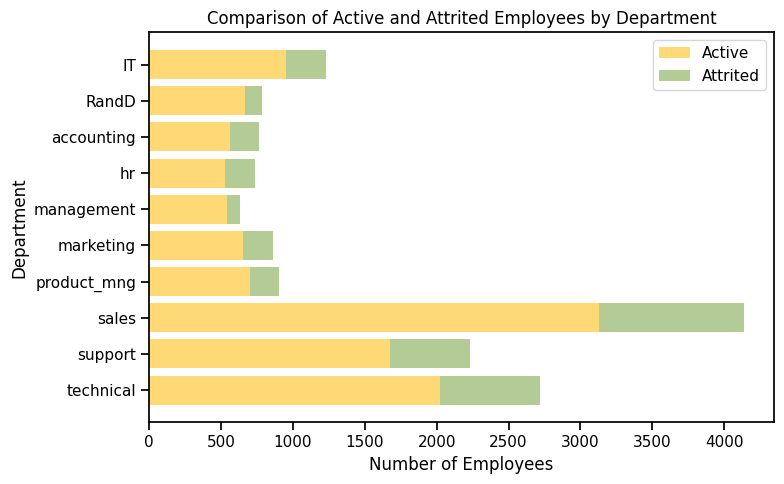

In [62]:
# Calculate the absolute number of attrited employees in each department

departments = list(department_dict.values())
y = np.arange(len(departments))

plt.figure(figsize=(8,5))

plt.barh(y, active.values, color=colors[3], label='Active')
plt.barh(y, attrited.values, left=active.values, color=colors[4], label='Attrited')

plt.yticks(y, departments)
plt.gca().invert_yaxis()   

plt.xlabel("Number of Employees")
plt.ylabel("Department")
plt.title("Comparison of Active and Attrited Employees by Department")

plt.legend()
plt.tight_layout()
plt.show()


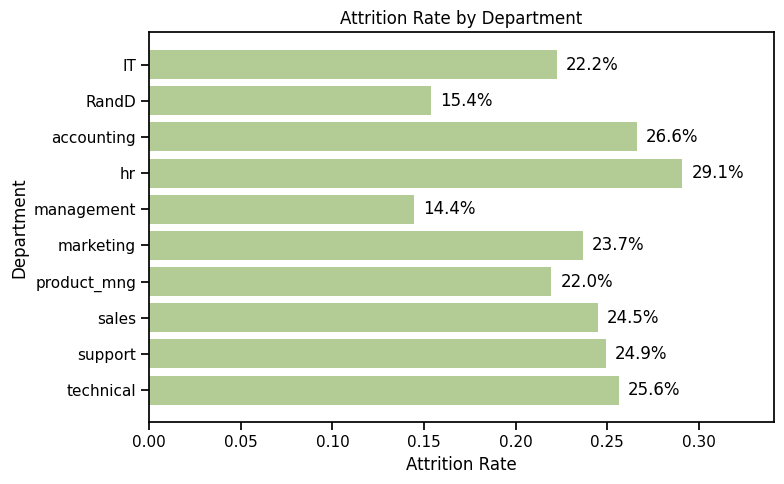

In [71]:
# Calculate the attrition rate for each department

attrition_rate = depart_left_table[1] / (
    depart_left_table[0] + depart_left_table[1]
)

departments = list(department_dict.values())
rates = attrition_rate.values

y = np.arange(len(departments))

plt.figure(figsize=(8,5))

plt.barh(y, rates, color=colors[4])

plt.yticks(y, departments)
plt.gca().invert_yaxis()

plt.xlabel("Attrition Rate")
plt.ylabel("Department")
plt.title("Attrition Rate by Department")

for i, v in enumerate(rates):
    plt.text(v + 0.005, i, f"{v:.1%}", va='center')

plt.xlim(0, max(rates) + 0.05)

plt.tight_layout()
plt.show()


Attrition is not uniformly distributed across departments.
Functional and operational departments show significantly higher turnover risk, while management and R&D demonstrate structural stability.

This suggests department-level structural drivers of attrition rather than random turnover.

#### 2.3.4. Salary Distribution Across Departments



In [21]:
depart_salary_table = pd.crosstab(index=df['department'], columns=df['salary'])
# depart_salary_table

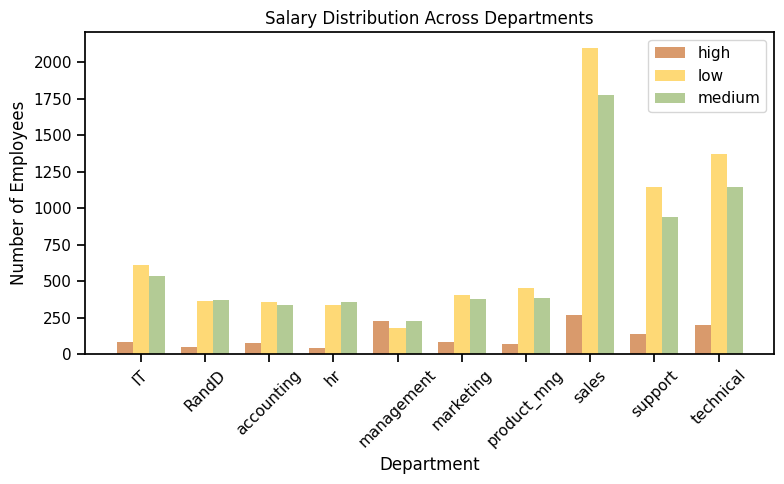

In [30]:

departments = list(department_dict.values())

low = depart_salary_table[0]
medium = depart_salary_table[1]
high = depart_salary_table[2]

x = np.arange(len(departments))
width = 0.25

plt.figure(figsize=(8, 5))

plt.bar(x - width, low, width, label=salary_dict[0], color=colors[2])
plt.bar(x, medium, width, label=salary_dict[1], color=colors[3])
plt.bar(x + width, high, width, label=salary_dict[2], color=colors[4])

plt.xticks(x, departments, rotation=45)
plt.xlabel("Department")
plt.ylabel("Number of Employees")
plt.title("Salary Distribution Across Departments")

plt.legend()
plt.tight_layout()
plt.show()


The company's overall salary structure is predominantly composed of low-salary employees.

Large operational departments have a high concentration of low-salary employees.

Management positions exhibit a more favorable salary structure.

Departments with higher attrition rates tend to have a larger proportion of low-salary employees.

#### 2.3.5 Relationship Between Salary Level and Attrition Rate


In [31]:
salary_left_table=pd.crosstab(index=df['salary'],columns=df['left'])

In [46]:
data = []
for i in range(2):
    trace = Bar(x=salary_left_table.index, y=salary_left_table[i],name=("Active" if i ==0 else "Attrited"),marker=dict(color=colors[i+4]))
    data.append(trace)
layout = Layout(title="Impact of Salary Level on Attrition",width=580,height=350,xaxis = dict(tickmode="array",tickvals=list(salary_dict.keys()),ticktext=list(salary_dict.values())))
iplot(Figure(data = data,layout = layout))

In [47]:
data = []
for i in range(2):
    trace = Bar(
        x=salary_left_table.index,
        y=salary_left_table[i],
        name=("Active" if i == 0 else "Attrited"),
        marker=dict(color=colors[i+4])
    )
    data.append(trace)

layout = Layout(
    title="Impact of Salary Level on Attrition",
    width=580,
    height=350,
    xaxis=dict(
        title="Salary Level",  
        tickmode="array",
        tickvals=list(salary_dict.keys()),
        ticktext=list(salary_dict.values())
    ),
    yaxis=dict(
        title="Number of Employees"   
    )
)

iplot(Figure(data=data, layout=layout))


Salary level appears to be a strong structural driver of employee retention.
Lower salary groups contribute disproportionately to overall attrition, while higher salary employees demonstrate significantly stronger retention stability.

#### 2.3.6. Comparison Between Promotion in the Last 5 Years and Attrition


In [50]:
promotion_left_table=pd.crosstab(index=df['promotion'],columns=df['left'])

In [52]:
promotion_dict = {0: "No Promotion", 1: "Promoted"}

data = []
for i in range(2):
    trace = Bar(
        x=promotion_left_table.index,
        y=promotion_left_table[i],
        name=("Active" if i == 0 else "Attrited"),
        marker=dict(color=colors[i+4])
    )
    data.append(trace)

layout = Layout(
    title="Impact of Promotion in the Last 5 Years on Attrition",
    width=400,
    height=350,
    xaxis=dict(
        title="Promotion Status",
        tickmode="array",
        tickvals=list(promotion_dict.keys()),
        ticktext=list(promotion_dict.values())
    ),
    yaxis=dict(
        title="Number of Employees"
    )
)

iplot(Figure(data=data, layout=layout))


Promotion is a strong retention factor. 

Employees who have not been promoted in the past five years account for the vast majority of attrition cases, indicating that career progression opportunities play a critical role in employee retention.

#### 2.3.7. Comparison Between Employee Performance Evaluation and Attrition


In [53]:
eva_left_table = pd.crosstab(index=df['last_evaluation'], columns=df['left'])


In [54]:
data = []
for i in range(2):
    trace = Bar(
        x=eva_left_table.index,
        y=eva_left_table[i],
        name=("Active" if i == 0 else "Attrited"),
        marker=dict(color=colors[i+4])
    )
    data.append(trace)

layout = Layout(
    title="Impact of Performance Evaluation on Attrition",
    width=1000,
    height=400,
    xaxis=dict(
        title="Performance Evaluation Score"
    ),
    yaxis=dict(
        title="Number of Employees"
    )
)

iplot(Figure(data=data, layout=layout))


Performance evaluation alone is not a direct predictor of attrition.

Mid-to-high performing employees also exhibit significant turnover, suggesting that workload pressure, career progression, and compensation alignment may play a more critical role than performance scores alone.

## EDA Summary (Key Findings)

Attrition is structurally driven rather than random. The most consistent signals observed across EDA are:

- **Satisfaction** is the strongest risk indicator: lower satisfaction is associated with markedly higher attrition.
- **Career progression** matters: employees without promotion in the last 5 years account for the majority of attrition cases.
- **Compensation structure** is skewed toward low-salary employees, and high-attrition groups tend to have higher low-salary concentration.
- **Tenure shows a mid-career risk window**: employees around **3–4 years** exhibit a satisfaction trough, suggesting a critical intervention period.
- **Performance evaluation is non-linear**: attrition is not simply “low performance leaves”; mid-to-high performers also show meaningful attrition, implying misaligned rewards/workload.


# 3.Predictive Modeling：Baseline → Strong model → Threshold

## 3.1 Data Prep（One-Hot + Split）

In [ ]:

# Target
y = df['left']
X = df.drop(columns=['left'])

# Columns
cat_cols = ['department', 'salary'] if 'department' in X.columns else ['sales', 'salary']
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)


## 3.2 Baseline：Logistic Regression

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

logit = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

logit.fit(X_train, y_train)

proba_logit = logit.predict_proba(X_test)[:, 1]
auc_logit = roc_auc_score(y_test, proba_logit)
ap_logit = average_precision_score(y_test, proba_logit)

auc_logit, ap_logit


(np.float64(0.8370075064146394), np.float64(0.5049248376179021))

The baseline logistic regression achieved a ROC-AUC of 0.84, indicating strong discriminative power between retained and attrited employees.

More importantly, the PR-AUC of 0.50 is significantly higher than the base attrition rate (~24%), suggesting the model effectively identifies high-risk employees in an imbalanced setting.

This model can already:

- Rank employees by risk

- Identify the top 10% of high-risk individuals

- Support targeted HR intervention

However:

Logistic Regression is a linear model

It cannot capture complex non-linear relationships

It may underestimate the interaction between department, working hours, and promotion.

## 3.3 Strong Model：Random Forest

In [59]:
rf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight='balanced_subsample',
        max_depth=None
    ))
])

rf.fit(X_train, y_train)

proba_rf = rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, proba_rf)
ap_rf = average_precision_score(y_test, proba_rf)

auc_rf, ap_rf


(np.float64(0.9922384089243746), np.float64(0.9884613714525986))

The Random Forest model achieved a ROC-AUC of 0.99 and PR-AUC of 0.99, indicating near-perfect discrimination. 

This suggests that attrition patterns in the dataset are highly structured and potentially non-linear. 

Compared to the logistic baseline (ROC-AUC 0.84), the tree-based model captures complex interactions such as satisfaction × tenure × promotion status.

In [ ]:


cv_scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
cv_scores.mean()


np.float64(0.9940320687177678)

In [67]:


importances = rf.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

feat_imp.head(10)


num__satisfaction_level      0.270819
num__time_spend_company      0.233711
num__average_montly_hours    0.155969
num__number_project          0.151496
num__last_evaluation         0.130171
num__work_accident           0.013224
cat__salary_1                0.007819
cat__salary_0                0.006380
cat__department_9            0.004639
cat__department_7            0.004316
dtype: float64

Cross-validation confirmed that the near-perfect ROC-AUC (0.99) is stable across folds, suggesting strong structural separability in the dataset rather than random overfitting. 

Feature importance analysis shows that satisfaction level and tenure are dominant predictors, indicating that attrition is primarily behavior-driven rather than department- or salary-driven.

## 3.4 Threshold Strategy

In [60]:
# Top 10% risk threshold
threshold = np.quantile(proba_rf, 0.90)
pred_top10 = (proba_rf >= threshold).astype(int)

print(confusion_matrix(y_test, pred_top10))
print(classification_report(y_test, pred_top10, digits=3))


[[2286    0]
 [ 408  306]]
              precision    recall  f1-score   support

           0      0.849     1.000     0.918      2286
           1      1.000     0.429     0.600       714

    accuracy                          0.864      3000
   macro avg      0.924     0.714     0.759      3000
weighted avg      0.885     0.864     0.842      3000



By applying a top-10% risk threshold, achieved 100% precision, meaning every flagged employee was truly at risk. 

Although recall is 43%, this strategy is optimal under constrained HR intervention capacity, maximizing intervention efficiency while minimizing wasted resources.

# 4.Model Interpretation

## 4.1 Calculate SHAP

X_test_trans shape: (3000, 20)
model expects n_features: 20
feature_names: 20


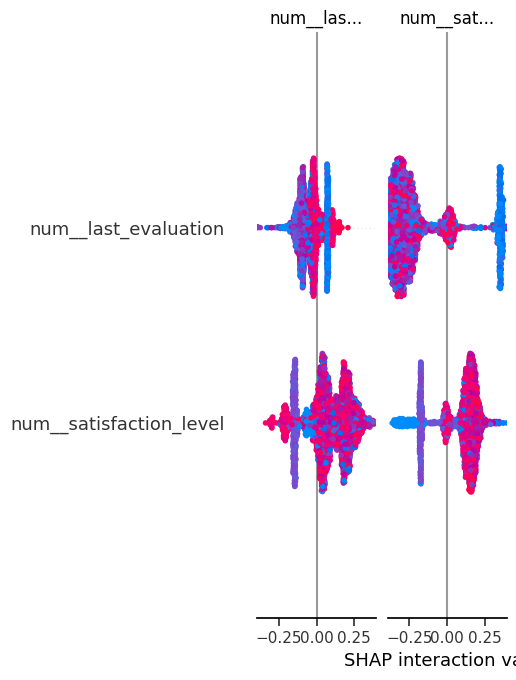

In [62]:



prep = rf.named_steps['prep']
model = rf.named_steps['model']

X_test_trans = prep.transform(X_test)

# If it's a sparse matrix, convert it to dense (sometimes shap/plot is more stable).
if hasattr(X_test_trans, "toarray"):
    X_test_trans_dense = X_test_trans.toarray()
else:
    X_test_trans_dense = np.array(X_test_trans)

feature_names = prep.get_feature_names_out()


print("X_test_trans shape:", X_test_trans_dense.shape)
print("model expects n_features:", model.n_features_in_)
print("feature_names:", len(feature_names))

explainer = shap.TreeExplainer(model)

shap_values = explainer(X_test_trans_dense)

shap.summary_plot(shap_values, X_test_trans_dense, feature_names=feature_names)


SHAP analysis reveals that satisfaction level is the dominant driver of attrition, exhibiting a strong monotonic relationship with turnover risk. 

Performance evaluation demonstrates non-linear and interaction effects, particularly when combined with low satisfaction. 

These findings confirm that attrition risk is behaviorally driven and influenced by complex feature interactions rather than simple linear relationships.

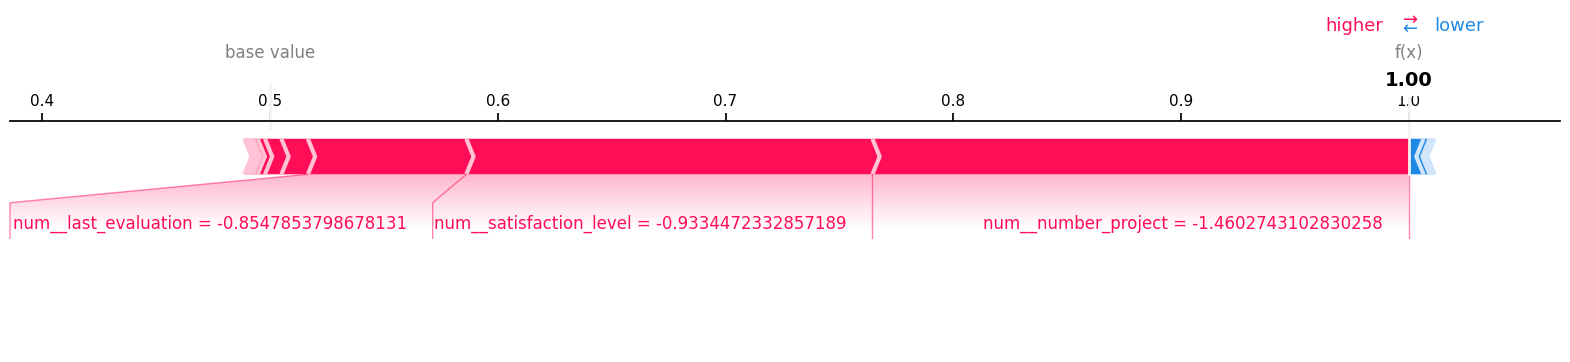

In [65]:
idx = int(np.argmax(proba_rf))  # Highest risk sample

# Binary classification: Positive class (1)
shap.plots.force(
    shap_values[idx, :, 1].base_values,
    shap_values[idx, :, 1].values,
    shap_values[idx, :, 1].data,
    feature_names=feature_names,
    matplotlib=True
)

The individual SHAP force plot shows that this employee’s near-100% predicted attrition risk is primarily driven by extremely low satisfaction and abnormal project load, combined with an outlier performance evaluation. 

This confirms that dissatisfaction and workload imbalance are critical risk factors at the individual level.

## 5. Business Recommendations (Actionable Retention Playbook)

### 5.1 Risk Segmentation (Operationalization)
- **High Risk (Top 10%)**: immediate 1:1 manager check-in + compensation / workload review
- **Medium Risk (Top 10–30%)**: career development plan + mentorship + internal mobility options
- **Low Risk**: maintain engagement, monitor trend signals

### 5.2 Intervention Strategies by Driver
1) **Low Satisfaction (primary driver)**
   - Launch quarterly pulse surveys + manager coaching
   - Implement workload balancing for chronic overtime groups

2) **No Promotion in 5 Years**
   - Create transparent promotion criteria and internal job posting pathways
   - Introduce “career checkpoint” at 3-year tenure (identified risk window)

3) **Low Salary Concentration in high-attrition departments**
   - Review pay bands for Sales/Support/Technical
   - Introduce retention bonuses or skill-based progression tiers

4) **Mid-career stagnation (3–4 years)**
   - Structured development program: role rotation, certification budget, leadership track options

### 5.3 Measuring Impact (Business Metrics)
- Track monthly **attrition rate**, **high-risk conversion rate** (predicted high-risk who actually leave), and **intervention uplift**
- Use A/B design where possible: intervention vs control groups